In [1]:
import pandas
import openpyxl
import os
import shutil
import cv2
import matplotlib.pyplot as plt

In [2]:
path_df = 'C:\\Users\\acer\\OneDrive\\Desktop\\Severity_train_partition.xlsx'
df=pandas.read_excel(path_df)
df

,Name,Category
0,ct_scan_3,1
1,ct_scan_5,1
2,ct_scan_15,1
3,ct_scan_16,1
4,ct_scan_18,1
...,...,...
457,ct_scan_631,4
458,ct_scan_638,4
459,ct_scan_639,4
460,ct_scan_668,4


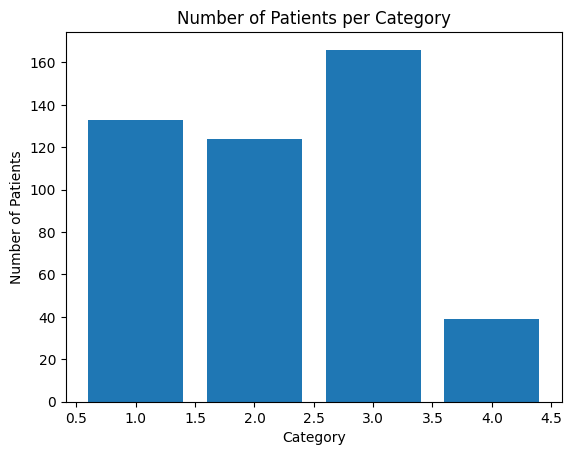

In [3]:
category_counts = df["Category"].value_counts()
category_names = category_counts.index.to_list()
patient_counts = category_counts.to_list()
plt.bar(category_names, patient_counts)
plt.xlabel("Category")
plt.ylabel("Number of Patients")
plt.title("Number of Patients per Category")
plt.show()

In [4]:
severity_1=[]
severity_2=[]
severity_3=[]
severity_4=[]
for el in range(len(df)):
    category=df['Category'][el]
    if category==1:
        severity_1.append(df["Name"][el])
    elif category==2:
        severity_2.append(df["Name"][el])
    elif category==3:
        severity_3.append(df["Name"][el])
    else:
        severity_4.append(df["Name"][el])
print(severity_4)

['ct_scan_1', 'ct_scan_215', 'ct_scan_231', 'ct_scan_245', 'ct_scan_250', 'ct_scan_299', 'ct_scan_406', 'ct_scan_441', 'ct_scan_452', 'ct_scan_459', 'ct_scan_488', 'ct_scan_492', 'ct_scan_507', 'ct_scan_508', 'ct_scan_510', 'ct_scan_516', 'ct_scan_517', 'ct_scan_522', 'ct_scan_525', 'ct_scan_530', 'ct_scan_531', 'ct_scan_538', 'ct_scan_545', 'ct_scan_546', 'ct_scan_547', 'ct_scan_548', 'ct_scan_566', 'ct_scan_567', 'ct_scan_575', 'ct_scan_576', 'ct_scan_597', 'ct_scan_601', 'ct_scan_602', 'ct_scan_626', 'ct_scan_631', 'ct_scan_638', 'ct_scan_639', 'ct_scan_668', 'ct_scan_686']


In [24]:
folder_directory = os.listdir("C:\\Users\\acer\\OneDrive\\Desktop\\TRAIN_DL")
usefull_folder = [folder for folder in folder_directory if folder in df['Name'].tolist()]

# Create the subfolders for categories
for category in df['Category'].unique():
    os.makedirs(f'{category}', exist_ok=True)

#Move the folders in the right directory according the category assigned in the excel files 
for index, row in df.iterrows():
    name_folder = row['Name']
    category = row['Category']
    if name_folder in usefull_folder:
        origin = f'C:\\Users\\acer\\OneDrive\\Desktop\\TRAIN_DL/{name_folder}'
        destination = f'{category}/{name_folder}'
        os.rename(origin, destination)

### Rename each scan with the folder name

In [7]:
def rinomina_immagini(cartella_paziente):
    elenco_immagini = os.listdir(cartella_paziente)
    #filename = os.path.basename(image_path)

    for indice, nome_immagine in enumerate(elenco_immagini):
        folder_name = os.path.dirname(os.path.join(cartella_paziente, nome_immagine))
        estensione = os.path.splitext(nome_immagine)[1]
        #nuovo_nome = f"paziente_{indice + 1}{estensione}"
        nuovo_nome = f"{folder_name}_{indice + 1}{estensione}"

        vecchio_percorso = os.path.join(cartella_paziente, nome_immagine)
        nuovo_percorso = os.path.join(cartella_paziente, nuovo_nome)

        os.rename(vecchio_percorso, nuovo_percorso)

# Sostituisci 'percorso/della/cartella' con il percorso effettivo della tua cartella paziente
percorso_cartella = "C:\\Users\\acer\\OneDrive\\Desktop\\VS_Folder\\DL_crop\\4_crop"

# Esegui la funzione per ogni cartella paziente
for paziente_cartella in os.listdir(percorso_cartella):
    cartella_paziente = os.path.join(percorso_cartella, paziente_cartella)

    if os.path.isdir(cartella_paziente):
        rinomina_immagini(cartella_paziente)

### Downscale the image

In [20]:
# Replace 'path/to/folder' with the actual path to your image folder
folder_path = "C:\\Users\\acer\\OneDrive\\Desktop\\VS_Folder\\DL_299\\4_299"

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):
        # Read the image
        image = cv2.imread(os.path.join(folder_path, filename))

        # Resize the image
        resized_image = cv2.resize(image, (299, 299), interpolation=cv2.INTER_AREA)

        # Overwrite the original image file with the resized version
        cv2.imwrite(os.path.join(folder_path, filename), resized_image)

### Creation of a dataset using the crop

In [13]:
def crop(img):
    # Copy the input image to avoid modifying the original
    img_copy = img.copy()
    
    # Define the cropping percentages
    height, width, channel = img_copy.shape
    height_2 = int(height * (20 / 100))
    width_2 = int(width * (100/ 100))
    
    # Set the top-left corner to black
    img_copy[0:height_2, 0:width_2] = [0, 0, 0]
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    
    # Apply binary thresholding
    _, thresh = cv2.threshold(gray, 15, 255, cv2.THRESH_BINARY)
    
    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the contour with the maximum area
    cnt = max(contours, key=cv2.contourArea)
    
    # Get the bounding rectangle
    x, y, w, h = cv2.boundingRect(cnt)
    
    # Crop the image using the bounding rectangle
    cropped = img_copy[y:y+h, x:x+w]
    
    cropped = cv2.resize(cropped, (224,224), interpolation=cv2.INTER_AREA)
    
    return cropped

In [17]:
# Replace 'path/to/folder' with the actual path to your image folder
folder_path = "C:\\Users\\acer\\OneDrive\\Desktop\\VS_Folder\\DL_crop\\4_crop"

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg'):
        # Read the image
        image = cv2.imread(os.path.join(folder_path, filename))

        # Resize the image
        cropped_image=crop(image)

        # Overwrite the original image file with the resized version
        cv2.imwrite(os.path.join(folder_path, filename), cropped_image)

### High Pass Gaussian Filter

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.filters import sobel
from scipy.ndimage import label
from scipy.ndimage.morphology import binary_closing
from skimage.filters import threshold_otsu
from scipy.ndimage.filters import gaussian_filter

In [ ]:
def fourier(image):
    b,g,r=cv2.split(image)
    im_f = np.fft.fft2(b)
    final_fourier = np.fft.fftshift(im_f)
    return final_fourier
def inverse_f(image):
    ishift_img = np.fft.ifftshift(image)
    ifft_img = np.fft.ifft2(ishift_img)
    abs_img = np.abs(ifft_img)
    return abs_img
def high_pass_gauss(image):
    fourier_img=fourier(image)
    # High-pass Gaussian filter parameters
    cutoff_frequency = 0.5 # Adjust this value based on your requirements
    sigma = 1 / (2 * np.pi* cutoff_frequency)
    filtered= gaussian_filter(fourier_img, sigma=0.48)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(np.log(abs(filtered)))
    gauss_img=inverse_f(filtered)
    plt.subplot(1,2,2)
    #plt.figure(num=None, figsize=(8, 6), dpi=80)
    plt.imshow(gauss_img, cmap='gray')

In [ ]:
gauss_img=high_pass_gauss(downscaled_covid)

### Removing subfolders

In [10]:
# Get the path to the main folder
main_folder_path = "C:\\Users\\acer\\OneDrive\\Desktop\\VS_Folder\\DL\\1"


# Get the paths to all subfolders
subfolder_paths = os.listdir(main_folder_path)

# For each subfolder, move its images to the main folder and delete the subfolder
for subfolder_path in subfolder_paths:
    # Get the path to the subfolder
    subfolder_path = os.path.join(main_folder_path, subfolder_path)

    # Get the path to the subfolder's images
    image_paths = os.listdir(subfolder_path)

    # For each image in the subfolder, move it to the main folder
    for image_path in image_paths:
        image_path = os.path.join(subfolder_path, image_path)
        shutil.move(image_path, main_folder_path)

    # Delete the subfolder
    shutil.rmtree(subfolder_path)

Error: Destination path 'C:\Users\acer\OneDrive\Desktop\VS_Folder\DL\1\paziente_1.jpg' already exists